## Setup

Import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import glob
import shutil
import seaborn as sns
from sklearn.metrics import classification_report
import warnings

2023-01-20 04:34:31.773264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
warnings.filterwarnings('ignore')

Make new directories for the images to be put into various different classes and directories to save the models after training them, 3 models are created in this notebook

In [5]:
os.makedirs("ds_final_assignment/cloudy",exist_ok=True)
os.makedirs("ds_final_assignment/green_area",exist_ok=True)
os.makedirs("ds_final_assignment/desert",exist_ok=True)
os.makedirs("ds_final_assignment/water",exist_ok=True)
os.makedirs("models/m1",exist_ok=True)
os.makedirs("models/m2",exist_ok=True)
os.makedirs("models/m3",exist_ok=True)


Move images to the desired directory by detecting the classes based on the filenames 

In [6]:
path = "ds_final_assignment/cloudy/"
path2="ds_final_assignment/desert"
path3="ds_final_assignment/water"
path4="ds_final_assignment/green_area"
files = glob.glob("ds_final_assignment/*cloudy*")
files2 = glob.glob("ds_final_assignment/*desert*")
files3 = glob.glob("ds_final_assignment/*water*")
files4 = glob.glob("ds_final_assignment/*green_area*")

for file in files:
    shutil.move(file, path)
for file2 in files2:
    shutil.move(file2, path2)
for file3 in files3:
    shutil.move(file3, path3)
for file4 in files4:
    shutil.move(file4, path4)

Assign the base directory where the dataset is stored including the home directory in this case directory is "D:\DataScience\ds_final_assignment".

In [2]:
from pathlib import Path

data_dir = Path('/Users/agamsanghera/Desktop/Study Material/6th Semester/Data Science/ds_final_assignment/ds_final_assignment').with_suffix('')

Count the images in the dataset

In [36]:
image_count = len(list(data_dir.glob('*\*.jpg')))
print(image_count)

0


Function to convert images of CMYK fromat into RGB

In [37]:
def conv(path):
    for x in path:
        image=PIL.Image.open(str(x))
        if image.mode == 'CMYK':
            image = image.convert('RGB')
            image.save(str(x))

Display an image from each class to check if the directory system is correctly installed

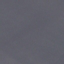

In [38]:
water = list(data_dir.glob('water/*'))
conv(water)
PIL.Image.open(str(water[7]))

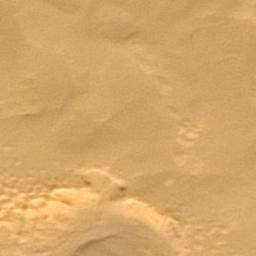

In [13]:
desert = list(data_dir.glob('desert/*'))
conv(desert)
PIL.Image.open(str(desert[0]))

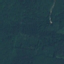

In [14]:
green = list(data_dir.glob('green_area/*'))
conv(green)
PIL.Image.open(str(green[0]))

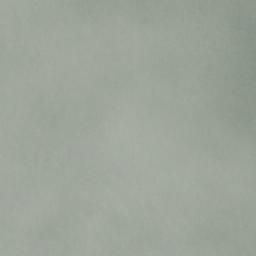

In [15]:
cloudy = list(data_dir.glob('cloudy/*'))
conv(cloudy)
PIL.Image.open(str(cloudy[590]))

## Load data using inbuilt dataloader utility

Loaded images off disk using `tf.keras.utils.image_dataset_from_directory` utility. 

### Creating the dataset

Fix batches for training and resize images to 50*50 pixels as instructed

In [16]:
batch_size = 50
img_height = 50
img_width = 50

Split the dataset

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4200 files belonging to 4 classes.
Using 3360 files for training.


2023-01-20 03:55:35.077407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4200 files belonging to 4 classes.
Using 840 files for validation.


Display the class names using the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [19]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'desert', 'green_area', 'water']


## Visualize the data

Here are the first nine images from the training dataset, these were obtained using the take() function of the PrefetchDataset object as the images can not be directly viewed otherwise. These images were then displyed using the matplotlib imshow() function

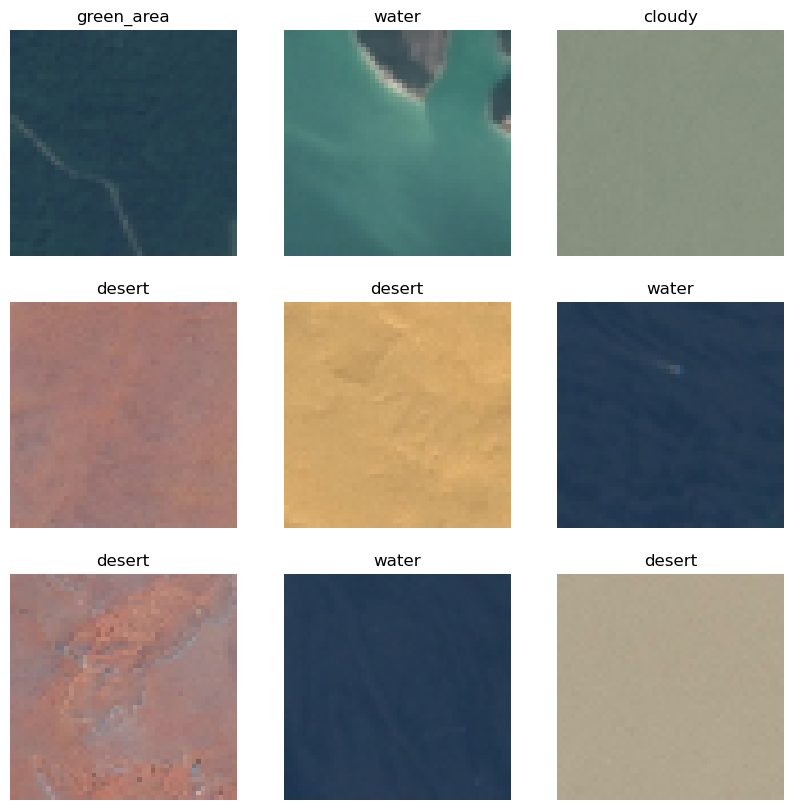

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The shape of the image and label batches are displayed below, directly iterating over the PrefetchDataset object gives the batches of images and labels

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 50, 50, 3)
(50,)


## Preprocessing the dataset

Used buffered prefetching, to yield data from disk without having I/O blocking. The following methods were used when loading data:

- `Dataset.cache` to keep the images in memory after loading from the disk during the first epoch. This is done to ensure that the dataset does not become a bottleneck while training the models.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.


The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. tf.data.AUTOTUNE does this job

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardizing data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; thus normalize the values between  `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [23]:
normalization_layer = layers.Rescaling(1./255)

## Model1

### Create the model

The Keras Sequential model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). 

In [24]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

The `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function were chosen, and training and validation accuracy for each training epoch were calculated by passing the `metrics` argument to `model1.compile`.

In [23]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [24]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

### Train the model

Trained the model for 100 epochs with the Keras `Model.fit` method:

In [25]:
epochs=100
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
68/68 [==============================] - 4s 45ms/step - loss: 0.6134 - accuracy: 0.7057 - val_loss: 0.4675 - val_accuracy: 0.7738
Epoch 2/100
68/68 [==============================] - 3s 41ms/step - loss: 0.4715 - accuracy: 0.7643 - val_loss: 0.4392 - val_accuracy: 0.7988
Epoch 3/100
68/68 [==============================] - 3s 42ms/step - loss: 0.3999 - accuracy: 0.8265 - val_loss: 0.3269 - val_accuracy: 0.8714
Epoch 4/100
68/68 [==============================] - 3s 42ms/step - loss: 0.3463 - accuracy: 0.8503 - val_loss: 0.3253 - val_accuracy: 0.8500
Epoch 5/100
68/68 [==============================] - 3s 41ms/step - loss: 0.2894 - accuracy: 0.8765 - val_loss: 0.3170 - val_accuracy: 0.8417
Epoch 6/100
68/68 [==============================] - 3s 42ms/step - loss: 0.2936 - accuracy: 0.8738 - val_loss: 0.2729 - val_accuracy: 0.8679
Epoch 7/100
68/68 [==============================] - 3s 42ms/step - loss: 0.3167 - accuracy: 0.8667 - val_loss: 0.3966 - val_accuracy: 0.8452
Epoch 

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

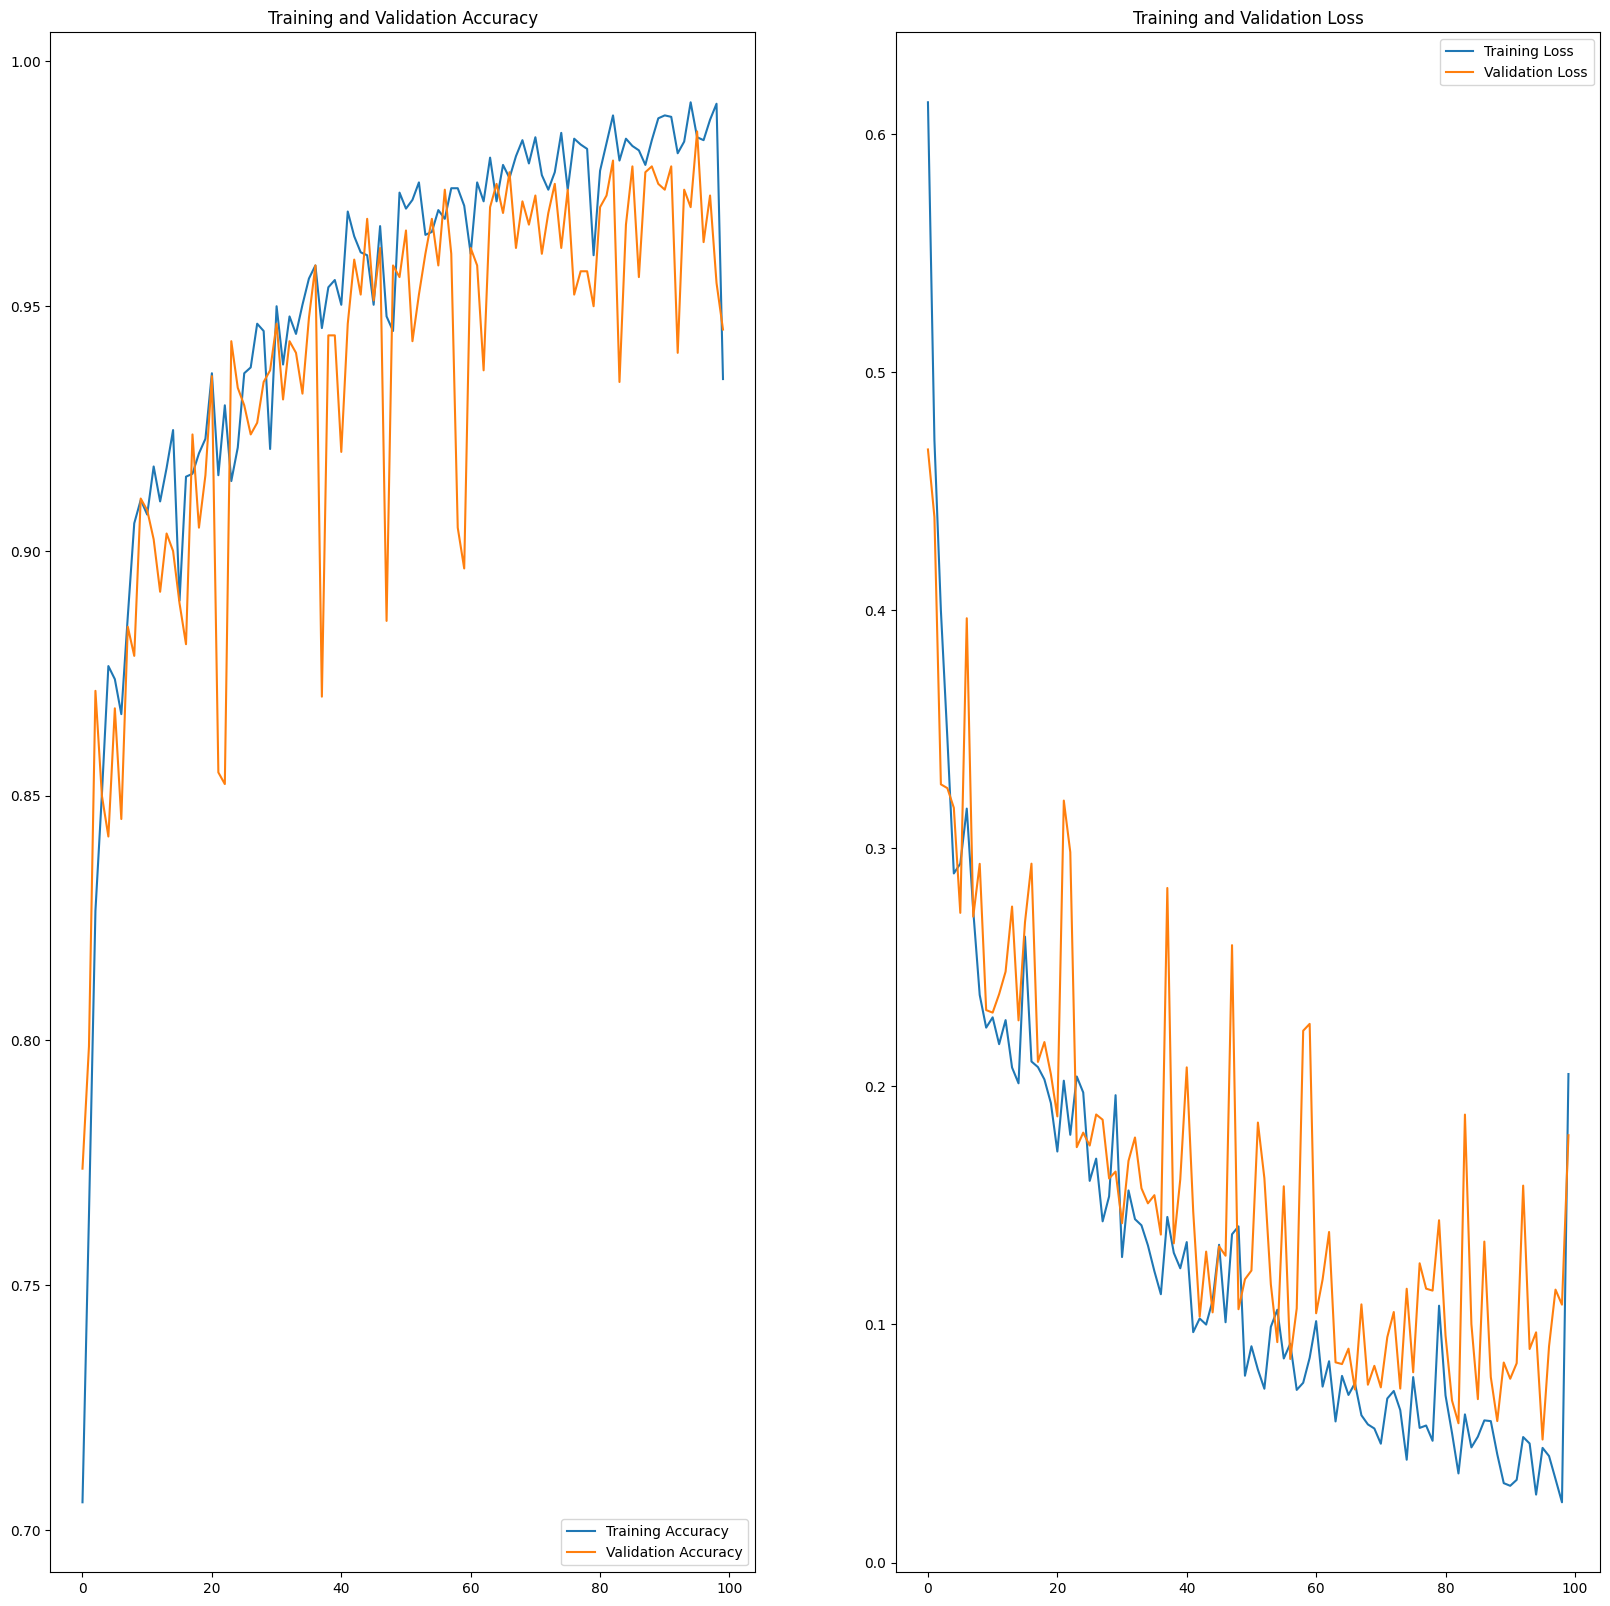

In [26]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Functions for plotting Confusion Matrix

First get the actual labels saved in the dataset, in thes case of this notebook train_ds and val_ds are used to save the training and validation datasets respectively.
dataset.unbatch() utility of the PrefetcheDataset type is used to obtain actual labels and the predicted labels are then predicted using the predict function of the model, these are then concatenated and the arg max is taken as the data is stored as a tensor

In [27]:
def get_actual_predicted_labels(dataset,model): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

Create the function to plot a confusion matrix using the actual and predicted labels 

In [28]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g',cmap="Blues")
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of classifaction ' + ds_type)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('Actual labels')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

Predict the data on the validation set and plot against the actual labels obtained previously to form the confusion matrix

17/17 [==============================] - 0s 9ms/step


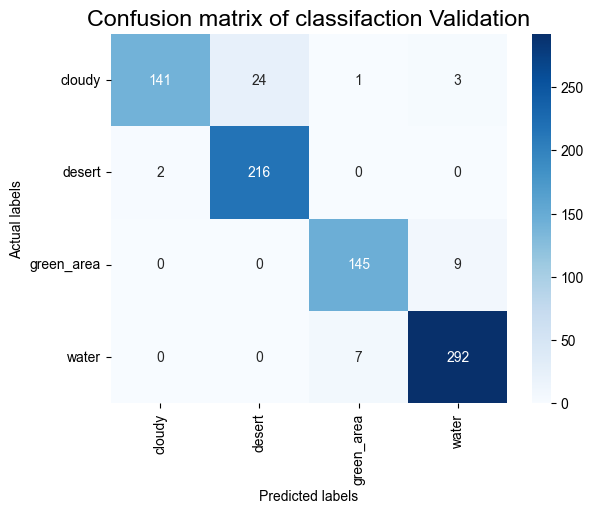

In [29]:
actuals,preds=get_actual_predicted_labels(val_ds,model1)
plot_confusion_matrix(actuals,preds,class_names,'Validation')

Print the name of the model, accuracy, class-wise precision, recall, and F1 score.

In [32]:
print(
    f"Classification report for classifier {model1}:\n"
    f"{classification_report(actuals,preds)}\n"
)

Classification report for classifier <keras.engine.sequential.Sequential object at 0x0000021E371F2920>:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       169
           1       0.90      0.99      0.94       218
           2       0.95      0.94      0.94       154
           3       0.96      0.98      0.97       299

    accuracy                           0.95       840
   macro avg       0.95      0.94      0.94       840
weighted avg       0.95      0.95      0.94       840




Save the model to device in the directory created previously to prevent the need for retraining the model

In [33]:
model1.save('model/m1')

INFO:tensorflow:Assets written to: model/m1\assets


INFO:tensorflow:Assets written to: model/m1\assets


The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Data augmentation

Data augmentation was implemented using the following Keras preprocessing layers: `tf.keras.layers.RandomZoom`, `tf.keras.layers.GuassianNoise`, and `tf.keras.layers.RandomRotation`. 

In [34]:
data_augmentation = keras.Sequential(
  [
    layers.GaussianNoise(stddev=0.1,input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Data augmentation will be added to the model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce dropout regularization to the network.

By applying dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [ ]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [37]:
model2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [38]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 50, 50, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

In [39]:
epochs = 100
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


68/68 [==============================] - 7s 56ms/step - loss: 0.6744 - accuracy: 0.6807 - val_loss: 0.4898 - val_accuracy: 0.7643
Epoch 2/100
68/68 [==============================] - 4s 57ms/step - loss: 0.4074 - accuracy: 0.8000 - val_loss: 0.4855 - val_accuracy: 0.7869
Epoch 3/100
68/68 [==============================] - 4s 55ms/step - loss: 0.3769 - accuracy: 0.8292 - val_loss: 0.3882 - val_accuracy: 0.8155
Epoch 4/100
68/68 [==============================] - 4s 61ms/step - loss: 0.3721 - accuracy: 0.8313 - val_loss: 0.4093 - val_accuracy: 0.8083
Epoch 5/100
68/68 [==============================] - 4s 55ms/step - loss: 0.3514 - accuracy: 0.8446 - val_loss: 0.3447 - val_accuracy: 0.8571
Epoch 6/100
68/68 [==============================] - 4s 54ms/step - loss: 0.3118 - accuracy: 0.8643 - val_loss: 0.4222 - val_accuracy: 0.8131
Epoch 7/100
68/68 [==============================] - 4s 58ms/step - loss: 0.3077 - accuracy: 0.8634 - val_loss: 0.3008 - val_accuracy: 0.8488
Epoch 8/100
68/68 

## Visualize training results


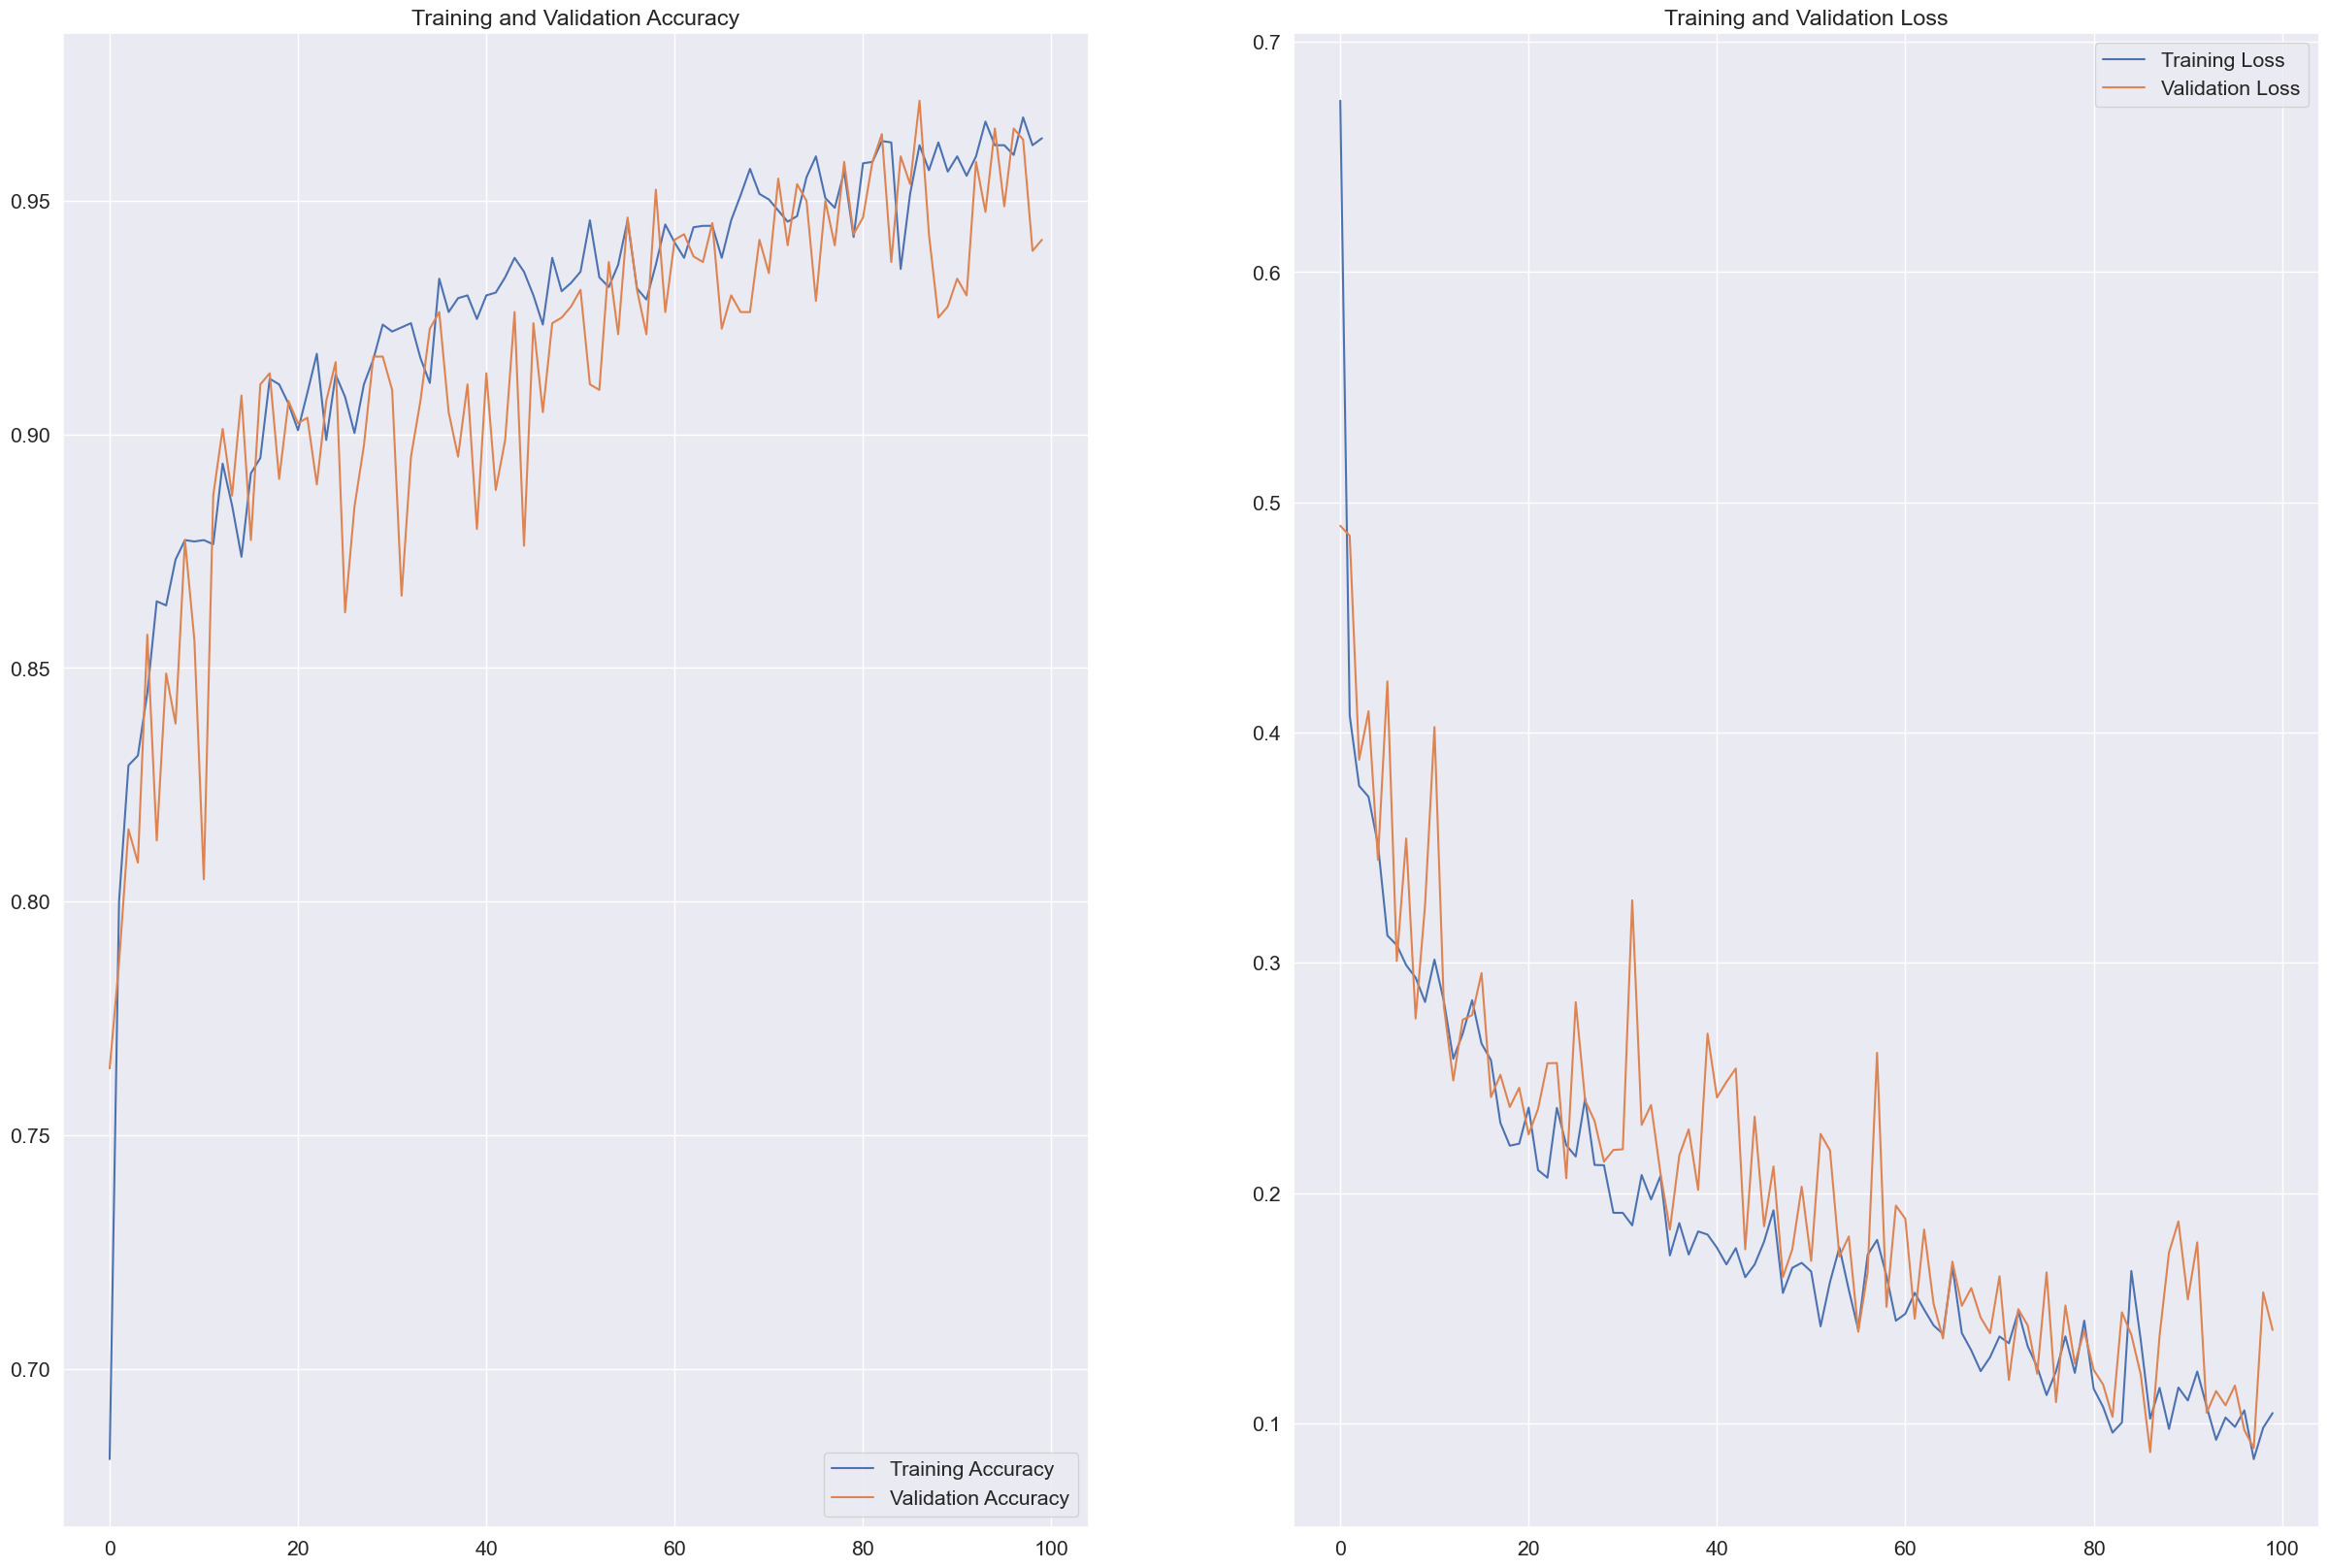

In [40]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model2

In [ ]:
model2.save('model/m2')

 Plot confusion matrix for model2
 

17/17 [==============================] - 0s 11ms/step


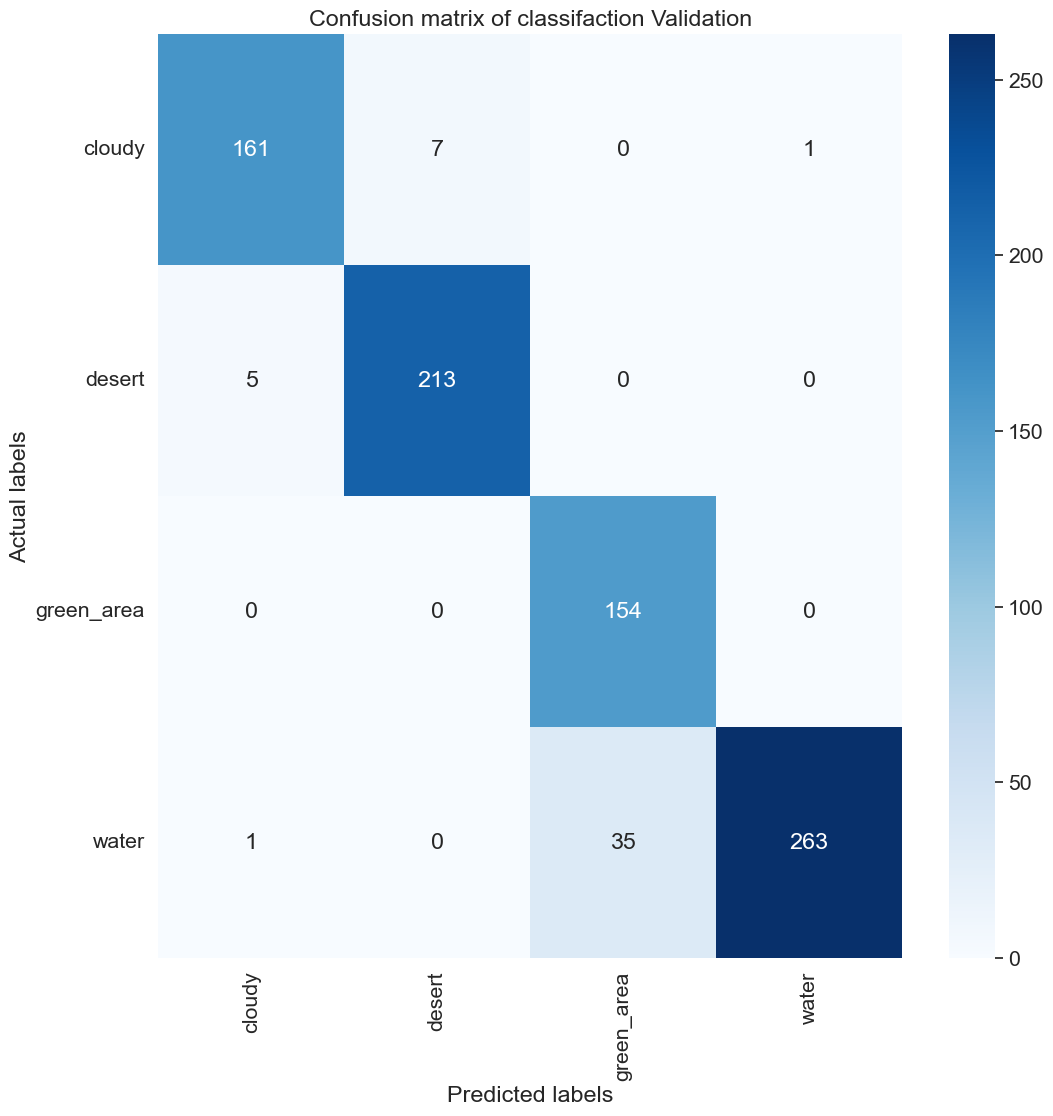

In [42]:
actual,predicted=get_actual_predicted_labels(val_ds,model2)
plot_confusion_matrix(actual,predicted,class_names,'Validation')

Print the name of the model, accuracy, class-wise precision, recall, and F1 score.

In [43]:
print(
    f"Classification report for classifier {model2}:\n"
    f"{classification_report(actual,predicted)}\n"
)

Classification report for classifier <keras.engine.sequential.Sequential object at 0x0000021E42001DE0>:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       169
           1       0.97      0.98      0.97       218
           2       0.81      1.00      0.90       154
           3       1.00      0.88      0.93       299

    accuracy                           0.94       840
   macro avg       0.94      0.95      0.94       840
weighted avg       0.95      0.94      0.94       840




## Transfer Learning

Transfer Learning is the process of using the knowledge obtained from learning a specific task and then applying it to another similar task so that lesser resources are wasted in retraining models from scratch

In this notebook the model `EfficientNetB0` is retrained without the weights, by just using the architecture on the dataset along with a `GlobalAveragePooling` layer and a `Dense` layer to classify the images correctly among 4 classes

In [44]:
base_model = tf.keras.applications.EfficientNetB0(weights=None, include_top=False, input_shape=(img_height,img_width) + (3,))

model3=Sequential([ 
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax',name="outputs")
  #layers.Dense(num_classes, name="outputs")
])

## Compile the model3

In [45]:
model3.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [46]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 outputs (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


Only ran 50 epochs as the processing time was very high due to a large number of trainable parameters

In [47]:
epochs = 50
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


C:\Users\agams\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


68/68 [==============================] - 45s 371ms/step - loss: 0.6891 - accuracy: 0.7348 - val_loss: 1.5009 - val_accuracy: 0.3560
Epoch 2/50
68/68 [==============================] - 25s 361ms/step - loss: 0.3866 - accuracy: 0.8592 - val_loss: 1.4316 - val_accuracy: 0.3560
Epoch 3/50
68/68 [==============================] - 24s 356ms/step - loss: 0.3318 - accuracy: 0.8744 - val_loss: 1.5163 - val_accuracy: 0.3560
Epoch 4/50
68/68 [==============================] - 24s 357ms/step - loss: 0.2181 - accuracy: 0.9226 - val_loss: 1.4940 - val_accuracy: 0.3560
Epoch 5/50
68/68 [==============================] - 24s 354ms/step - loss: 0.1638 - accuracy: 0.9458 - val_loss: 1.4370 - val_accuracy: 0.3881
Epoch 6/50
68/68 [==============================] - 24s 353ms/step - loss: 0.1346 - accuracy: 0.9545 - val_loss: 1.4792 - val_accuracy: 0.5512
Epoch 7/50
68/68 [==============================] - 24s 357ms/step - loss: 0.0944 - accuracy: 0.9673 - val_loss: 1.5110 - val_accuracy: 0.4964
Epoch 8/50

## Visualize Training Results

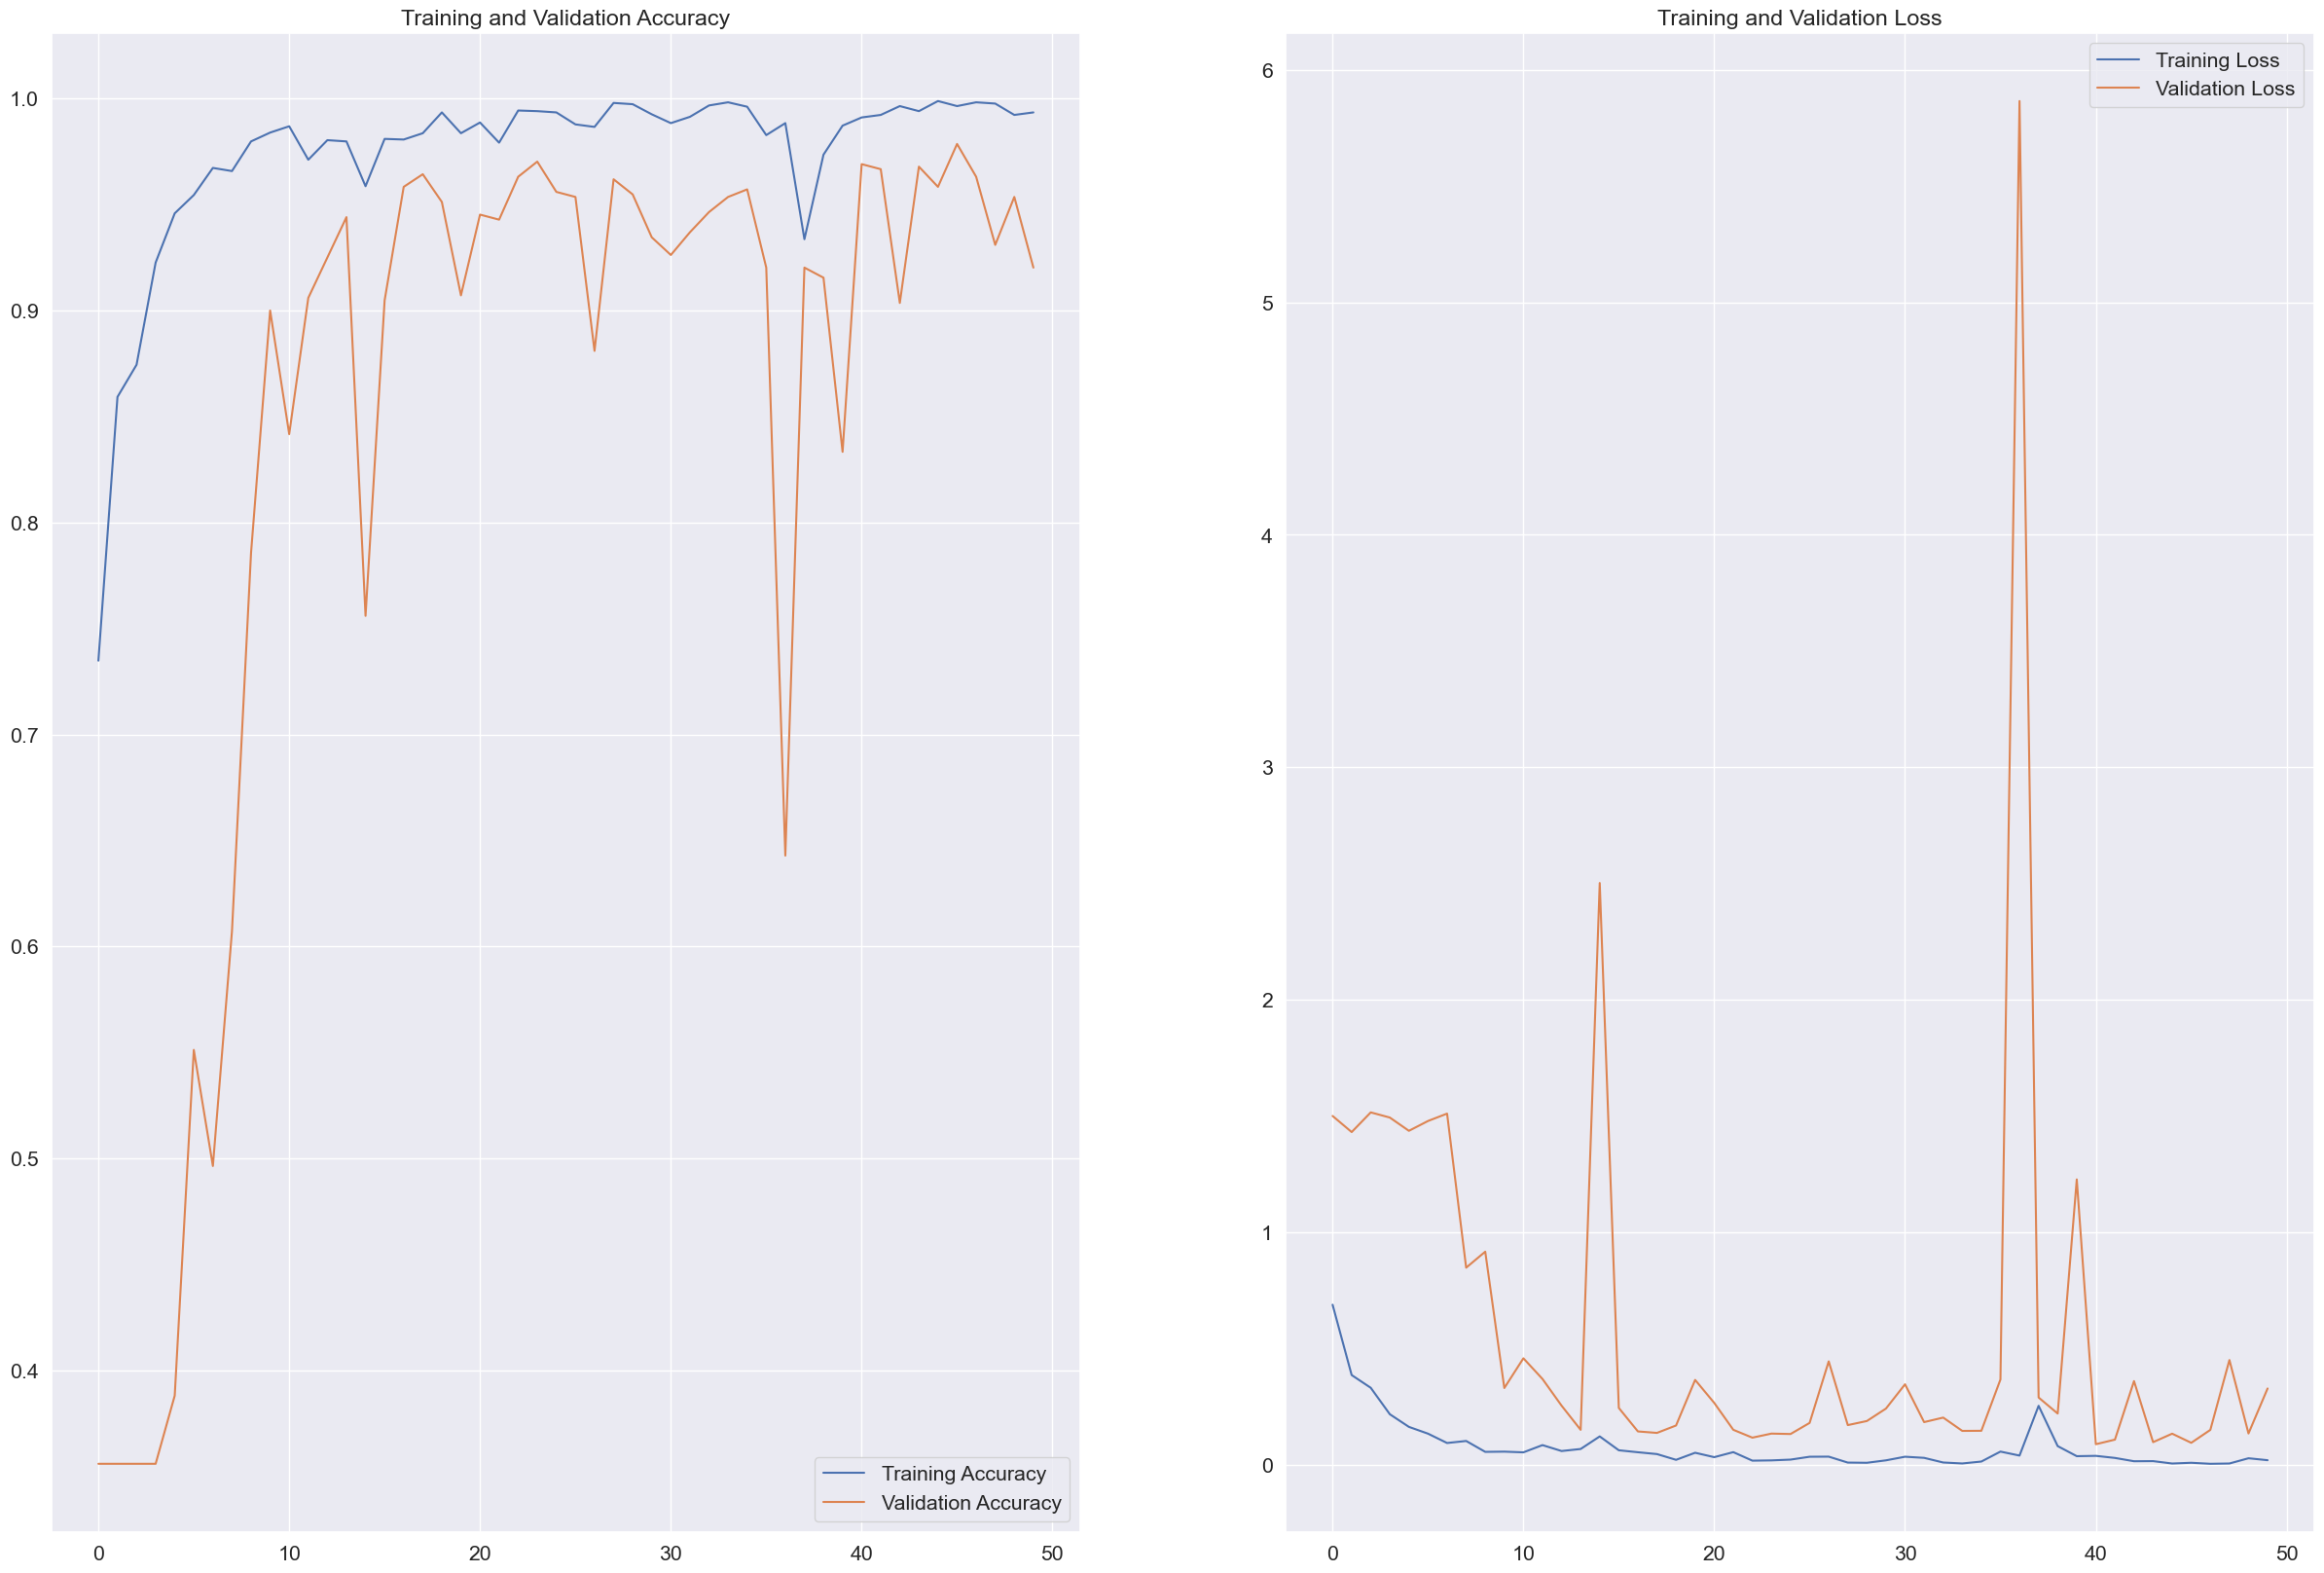

In [48]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(30, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

PLot the confusion matrix

17/17 [==============================] - 3s 75ms/step


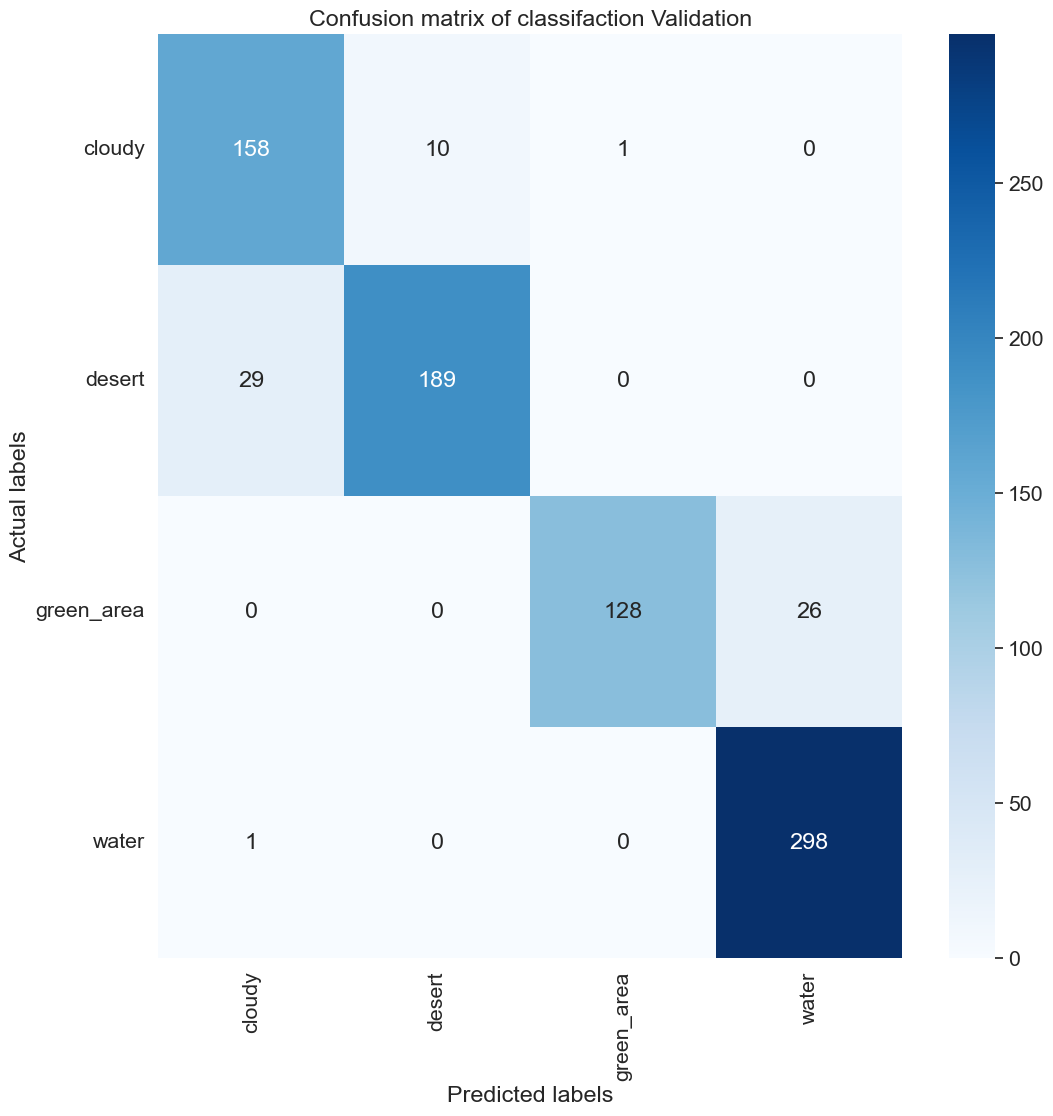

In [49]:

actual2,predicted2=get_actual_predicted_labels(val_ds,model3)
plot_confusion_matrix(actual2,predicted2,class_names,'Validation')

Print the name of the model, accuracy, class-wise precision, recall, and F1 score.

In [50]:
print(
    f"Classification report for classifier {model3}:\n"
    f"{classification_report(actual2,predicted2)}\n"
)

Classification report for classifier <keras.engine.sequential.Sequential object at 0x0000021E51A83D00>:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       169
           1       0.95      0.87      0.91       218
           2       0.99      0.83      0.90       154
           3       0.92      1.00      0.96       299

    accuracy                           0.92       840
   macro avg       0.93      0.91      0.91       840
weighted avg       0.92      0.92      0.92       840




## Save model3

In [51]:
model3.save('model/m3')

INFO:tensorflow:Assets written to: model/m3\assets


INFO:tensorflow:Assets written to: model/m3\assets


## Loading the previously saved model

Load the model using `tf.keras.models.load_model()` function and passing the location of the directory where the model is stored as a string, the case of this notebook, it will be stored in 'model/m3' and that is where the transfer learning model is loaded from and the architecture can be viewed by using the summary() utility of the `keras.engine.sequential.Sequential` object

In [10]:
new_model = tf.keras.models.load_model('model/m1')

In [11]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

loss and accuracy can be verified by evaluating the model over the loaded dataset (train_ds) by using the evaluate() utility of the `keras.engine.sequential.Sequential` object

In [27]:
loss, acc = new_model.evaluate(train_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

68/68 - 24s - loss: 0.1310 - accuracy: 0.9565 - 24s/epoch - 358ms/step
Restored model, accuracy: 95.65%


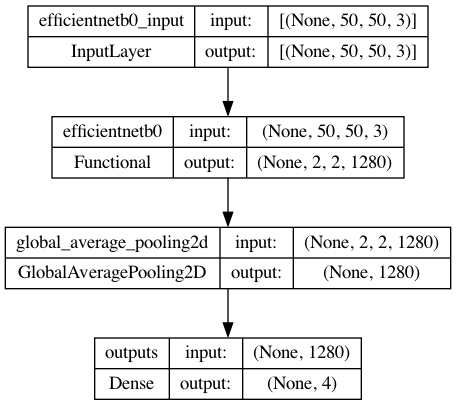

In [6]:
tf.keras.utils.plot_model(new_model,to_file='model2.png',show_shapes=True)

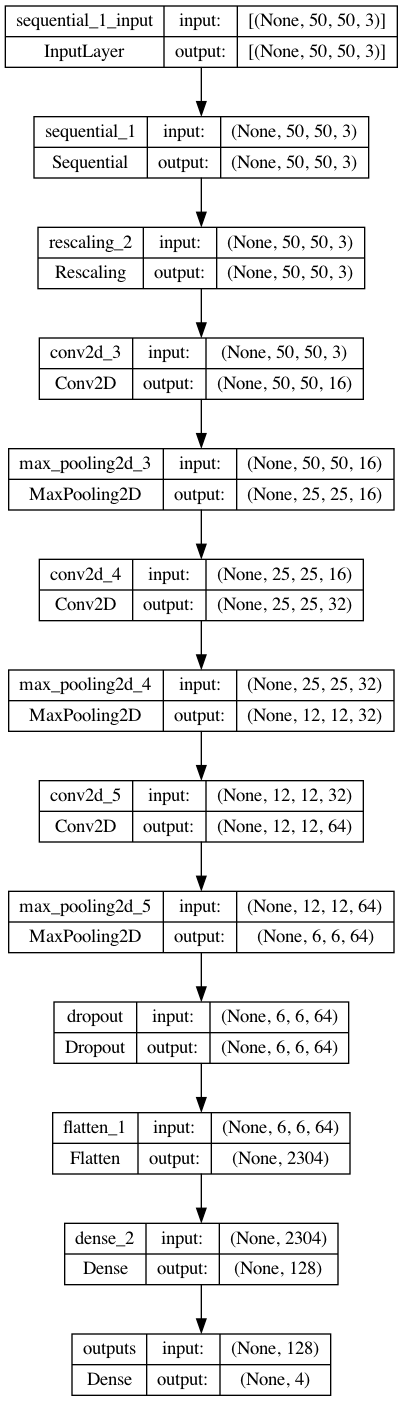

In [9]:
tf.keras.utils.plot_model(new_model,to_file='model2.png',show_shapes=True)

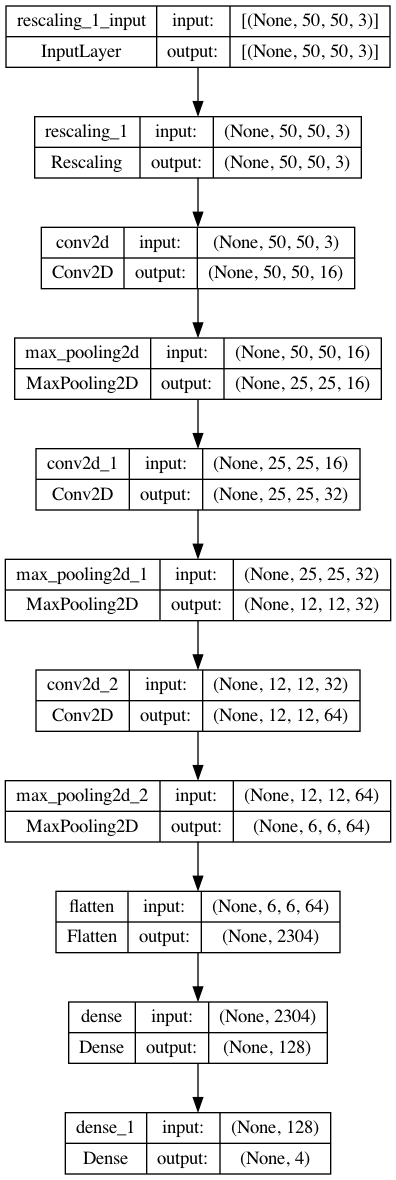

In [12]:
tf.keras.utils.plot_model(new_model,to_file='model3.png',show_shapes=True)